In [1]:
import utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import logging

In [2]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.7.0
	• tf.keras version: 2.7.0
	• GPU device not found. Running on CPU


In [3]:
basedir = os.path.join("D:\my_code_2\my_code\metacovid-siamese-neural-network-main\metacovid-siamese-neural-network-main\scripts", "dataset", "siamese") 

train_image_list, train_y_list = utils.load_images(basedir, 'train', (100,100))
print("The train set contains",len(train_image_list)) 

valid_image_list, valid_y_list = utils.load_images(basedir, 'validation', (100,100))   
print("The valid set contains", len(valid_image_list))  

test_image_list, test_y_list = utils.load_images(basedir, 'test', (100,100))   
print("The test set contains", len(test_image_list)) 

Found 30 images belonging to 3 classes.
The train set contains 30
Found 30 images belonging to 3 classes.
The valid set contains 30
Found 648 images belonging to 3 classes.
The test set contains 648


In [4]:
# make train pairs
pairs_train, labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make test pairs
pairs_test, labels_test = utils.make_pairs(test_image_list, test_y_list)

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]
print("number of pairs for training", np.shape(x_train_1)[0]) 

x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0]) 

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]
print("number of pairs for test", np.shape(x_test_1)[0]) 

number of pairs for training 60
number of pairs for validation 60
number of pairs for test 1296


In [5]:
tf.compat.v1.reset_default_graph()

SIAMESE_MODEL_FNAME = 'siamese_network.h5'
EMBEDDING_MODEL_FNAME = 'embedding_network.h5'

input_1 = Input((100,100,3))
input_2 = Input((100,100,3))

embedding_network = tf.keras.models.load_model("D:\my_code_2\my_code\metacovid-siamese-neural-network-main\metacovid-siamese-neural-network-main\scripts\embedding_network.h5")
embedding_network.trainable = False

model = tf.keras.Sequential() 
for layer in embedding_network.layers:  
    model.add(layer) 

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2')) 
 
output_1 = model(input_1) 
output_2 = model(input_2) 
 
merge_layer = Lambda(utils.manhattan_distance)([output_1, output_2]) 
output_layer = Dense(1, activation="sigmoid")(merge_layer) 
siamese = Model(inputs=[input_1, input_2], outputs=output_layer) 
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14748995    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [6]:
""" callbacks """

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath='siamese_network.h5', verbose=1, 
                                save_best_only=True)

In [7]:
""" train the model """

optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=utils.loss(1), optimizer=optimizer, metrics=["accuracy"])
# siamese.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=1,
    epochs=175,   # 175 for contrastive 100 for cross ent
    callbacks = [checkpointer, early_stopping, reduce_lr]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14748995    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

60/60 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.7167
Epoch 00020: val_loss improved from 0.14755 to 0.14587, saving model to siamese_network.h5
60/60 [==============================] - 11s 184ms/step - loss: 0.1535 - accuracy: 0.7167 - val_loss: 0.1459 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 21/175
60/60 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.6833
Epoch 00021: val_loss did not improve from 0.14587
60/60 [==============================] - 11s 190ms/step - loss: 0.1508 - accuracy: 0.6833 - val_loss: 0.1467 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 22/175
60/60 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.7167
Epoch 00022: val_loss improved from 0.14587 to 0.14376, saving model to siamese_network.h5
60/60 [==============================] - 12s 197ms/step - loss: 0.1530 - accuracy: 0.7167 - val_loss: 0.1438 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 23/175
60/60 [=========================

Epoch 46/175
60/60 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.8000
Epoch 00046: val_loss did not improve from 0.13057
60/60 [==============================] - 11s 191ms/step - loss: 0.1378 - accuracy: 0.8000 - val_loss: 0.1315 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 47/175
60/60 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.8667
Epoch 00047: val_loss improved from 0.13057 to 0.12957, saving model to siamese_network.h5
60/60 [==============================] - 11s 187ms/step - loss: 0.1380 - accuracy: 0.8667 - val_loss: 0.1296 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 48/175
60/60 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.8833
Epoch 00048: val_loss did not improve from 0.12957
60/60 [==============================] - 11s 185ms/step - loss: 0.1358 - accuracy: 0.8833 - val_loss: 0.1303 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 49/175
60/60 [==============================] - ETA: 0s - loss: 0.

Epoch 72/175
60/60 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.8833
Epoch 00072: val_loss did not improve from 0.11868
60/60 [==============================] - 11s 187ms/step - loss: 0.1284 - accuracy: 0.8833 - val_loss: 0.1258 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 73/175
60/60 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.8500
Epoch 00073: val_loss did not improve from 0.11868
60/60 [==============================] - 11s 186ms/step - loss: 0.1295 - accuracy: 0.8500 - val_loss: 0.1193 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 74/175
60/60 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9000
Epoch 00074: val_loss improved from 0.11868 to 0.11867, saving model to siamese_network.h5
60/60 [==============================] - 11s 184ms/step - loss: 0.1248 - accuracy: 0.9000 - val_loss: 0.1187 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 75/175
60/60 [==============================] - ETA: 0s - loss: 0.

60/60 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9000
Epoch 00098: val_loss did not improve from 0.10840
60/60 [==============================] - 11s 187ms/step - loss: 0.1178 - accuracy: 0.9000 - val_loss: 0.1086 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 99/175
60/60 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9500
Epoch 00099: val_loss improved from 0.10840 to 0.10763, saving model to siamese_network.h5
60/60 [==============================] - 11s 188ms/step - loss: 0.1154 - accuracy: 0.9500 - val_loss: 0.1076 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 100/175
60/60 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.8833
Epoch 00100: val_loss improved from 0.10763 to 0.10733, saving model to siamese_network.h5
60/60 [==============================] - 11s 188ms/step - loss: 0.1151 - accuracy: 0.8833 - val_loss: 0.1073 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 101/175
60/60 [=======================

60/60 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9167
Epoch 00124: val_loss did not improve from 0.09984
60/60 [==============================] - 11s 185ms/step - loss: 0.1103 - accuracy: 0.9167 - val_loss: 0.1005 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 125/175
60/60 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9333
Epoch 00125: val_loss improved from 0.09984 to 0.09946, saving model to siamese_network.h5
60/60 [==============================] - 11s 186ms/step - loss: 0.1058 - accuracy: 0.9333 - val_loss: 0.0995 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 126/175
60/60 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.9667
Epoch 00126: val_loss did not improve from 0.09946
60/60 [==============================] - 11s 185ms/step - loss: 0.1076 - accuracy: 0.9667 - val_loss: 0.1012 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 127/175
60/60 [==============================] - ETA: 0s - loss: 0.1054 - acc

60/60 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9833
Epoch 00150: val_loss did not improve from 0.09078
60/60 [==============================] - 11s 184ms/step - loss: 0.0988 - accuracy: 0.9833 - val_loss: 0.0912 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 151/175
60/60 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9500
Epoch 00151: val_loss did not improve from 0.09078
60/60 [==============================] - 11s 184ms/step - loss: 0.0995 - accuracy: 0.9500 - val_loss: 0.0912 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 152/175
60/60 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9833
Epoch 00152: val_loss improved from 0.09078 to 0.09010, saving model to siamese_network.h5
60/60 [==============================] - 11s 186ms/step - loss: 0.0986 - accuracy: 0.9833 - val_loss: 0.0901 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 153/175
60/60 [==============================] - ETA: 0s - loss: 0.0972 - acc

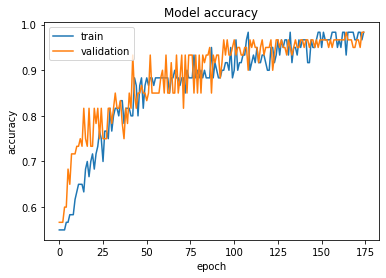

In [8]:
# Plot the accuracy
utils.plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

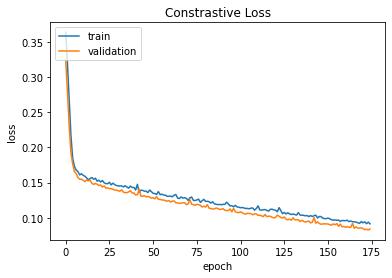

In [9]:
# Plot the constrastive loss
utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [10]:
""" Test the model """
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

41/41 [==============================] - 94s 2s/step - loss: 0.0999 - accuracy: 0.9336
test loss, test acc: [0.09994036704301834, 0.9336419701576233]


In [11]:
Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
Y_pred

array([0.6482859 , 0.1813162 , 0.6389365 , ..., 0.18665549, 0.649411  ,
       0.03620934], dtype=float32)

In [12]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = Y_pred > .5
y_pred

array([ True, False,  True, ..., False,  True, False])

In [13]:
y_test = labels_test
y_test

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [14]:
print("\nEvaluate on test data")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, y_pred, average='weighted'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))


Evaluate on test data
Accuracy: 0.933641975308642
Precision: 0.9393718571139016
Recall: 0.933641975308642
ROC AUC: 0.9336419753086419
F1: 0.9334249226468515


In [15]:
cm = confusion_matrix(y_test, y_pred)    
# cm_display = ConfusionMatrixDisplay(cm, labels_test).plot()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)

Specificity: 0.9907407407407407


In [16]:
tf.keras.backend.clear_session()